In [1]:
from PIL import Image
import torch
from torch.utils import data 
import numpy as np
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import torchvision.models as models
import pandas as pd

In [2]:
#数据归一化 [-1,1]#
train_transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],
                                    std=[0.5,0.5,0.5]),
])

test_transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],
                                    std=[0.5,0.5,0.5]),
])

verif_transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5],
                                    std=[0.5,0.5,0.5]),
])

In [3]:
train_dataset=torchvision.datasets.ImageFolder(
  'D:/VRSWE/CNNSWE2/train',
    transform=train_transformer
)

test_dataset=torchvision.datasets.ImageFolder(
  'D:/VRSWE/CNNSWE2/test',
   transform=test_transformer
)

verif_dataset=torchvision.datasets.ImageFolder(
  'D:/VRSWE/CNNSWE2/verif',
   transform=verif_transformer
) 

In [4]:
train_dataset.classes

['mild', 'modseve']

In [5]:
train_dataset.class_to_idx

{'mild': 0, 'modseve': 1}

In [6]:
id_to_class={}
for k,v in train_dataset.class_to_idx.items():
    print(k,v)
    id_to_class[v]=k
id_to_class

mild 0
modseve 1


{0: 'mild', 1: 'modseve'}

In [7]:
Batch_size= 32
dl_train=torch.utils.data.DataLoader(
        train_dataset,
        batch_size=Batch_size,
        shuffle=True
)
dl_test=torch.utils.data.DataLoader(
        test_dataset,
        batch_size=Batch_size,
        shuffle=False
)
dl_verif=torch.utils.data.DataLoader(
        verif_dataset,
        batch_size=Batch_size,
        shuffle=True
)

In [8]:
img,label=next(iter(dl_train))

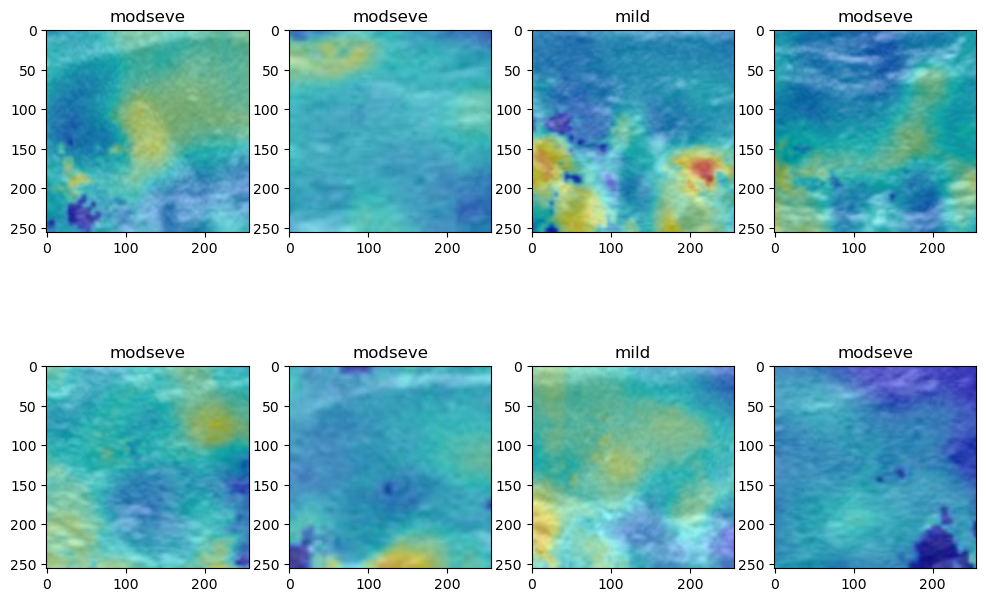

In [9]:
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(img[:8],label[:8])):
    img=(img.permute(1,2,0).numpy()+1)/2
    plt.subplot(2,4,i+1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img) 

In [10]:
######建立Res-net
res_net=torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = res_net.fc.in_features
res_net.fc = torch.nn.Linear(num_ftrs, 2)
model=res_net

In [11]:
#损失函数
loss_fn=nn.CrossEntropyLoss() 

In [25]:
#优化器和学习速率衰减
from torch.optim import lr_scheduler
optim=torch.optim.Adam(model.parameters(),lr=0.000002)
#scheduler = lr_scheduler.StepLR(optim,step_size=5,gamma = 0.5)

In [27]:
if torch.cuda.is_available():
    model.to('cuda')
torch.cuda.is_available()

True

In [29]:
def fit(epoch, model, trainloader, verifloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in tqdm(trainloader):
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
    verif_correct = 0
    verif_total = 0
    verif_running_loss = 0 
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(verifloader):
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            verif_correct += (y_pred == y).sum().item()
            verif_total += y.size(0)
            verif_running_loss += loss.item()
    
    epoch_verif_loss = verif_running_loss / len(verifloader.dataset)
    epoch_verif_acc = verif_correct / verif_total
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'verif_loss： ', round(epoch_verif_loss, 3),
          'verif_accuracy:', round(epoch_verif_acc, 3))
        
    return epoch_loss, epoch_acc, epoch_verif_loss, epoch_verif_acc

In [31]:
epochs = 15

In [33]:
patience = 3  # 早停策略的耐心值，即验证集性能没有提升的最大轮数
best_verif_loss = float('inf')
best_verif_acc = float('inf')
early_stopping_counter = 0

train_loss = []
train_acc = []
verif_loss = []
verif_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_verif_loss, epoch_verif_acc = fit(epoch,
                                                                   model,
                                                                   dl_train,
                                                                   dl_verif)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    verif_loss.append(epoch_verif_loss)
    verif_acc.append(epoch_verif_acc)

    # 早停策略
    if epoch_verif_loss < best_verif_loss or epoch_verif_acc > best_verif_acc:
        best_verif_loss = epoch_verif_loss
        best_verif_acc  = epoch_verif_acc
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.28it/s]


epoch:  0 loss：  0.021 accuracy: 0.585 verif_loss：  0.024 verif_accuracy: 0.563


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.13it/s]


epoch:  1 loss：  0.017 accuracy: 0.767 verif_loss：  0.02 verif_accuracy: 0.667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.89it/s]


epoch:  2 loss：  0.014 accuracy: 0.862 verif_loss：  0.015 verif_accuracy: 0.92


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.87it/s]


epoch:  3 loss：  0.013 accuracy: 0.89 verif_loss：  0.013 verif_accuracy: 0.954


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.23it/s]


epoch:  4 loss：  0.011 accuracy: 0.917 verif_loss：  0.011 verif_accuracy: 0.966


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.09it/s]


epoch:  5 loss：  0.01 accuracy: 0.917 verif_loss：  0.01 verif_accuracy: 0.954


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.27it/s]


epoch:  6 loss：  0.009 accuracy: 0.942 verif_loss：  0.009 verif_accuracy: 0.954


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.63it/s]


epoch:  7 loss：  0.008 accuracy: 0.932 verif_loss：  0.008 verif_accuracy: 0.954


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.26it/s]


epoch:  8 loss：  0.007 accuracy: 0.943 verif_loss：  0.007 verif_accuracy: 0.954


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.99it/s]


epoch:  9 loss：  0.007 accuracy: 0.938 verif_loss：  0.007 verif_accuracy: 0.966


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.50it/s]


epoch:  10 loss：  0.006 accuracy: 0.955 verif_loss：  0.006 verif_accuracy: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.21it/s]


epoch:  11 loss：  0.006 accuracy: 0.952 verif_loss：  0.006 verif_accuracy: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.90it/s]


epoch:  12 loss：  0.006 accuracy: 0.95 verif_loss：  0.006 verif_accuracy: 0.977


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.90it/s]


epoch:  13 loss：  0.005 accuracy: 0.955 verif_loss：  0.005 verif_accuracy: 0.966


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.97it/s]


epoch:  14 loss：  0.005 accuracy: 0.962 verif_loss：  0.005 verif_accuracy: 0.977


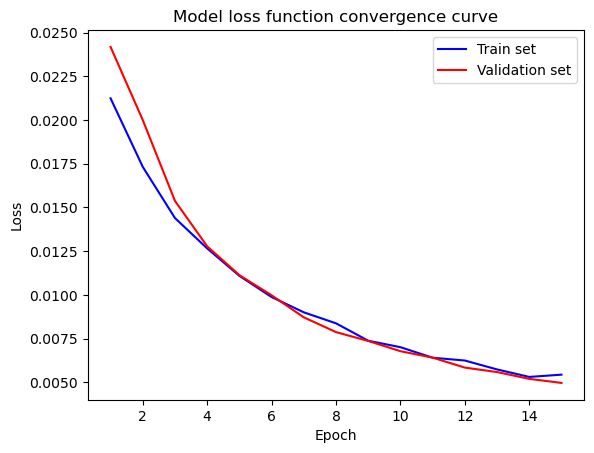

In [34]:
####损失函数
plt.plot(range(1, len(train_loss)+1), train_loss, label='Train set', color='#0000FF')
plt.plot(range(1, len(verif_loss)+1), verif_loss, label='Validation set', color='#FF0000')
plt.title('Model loss function convergence curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
SFig1 = plt.gcf() 
SFig1.savefig(r'D:\CNNswe\res_LOSS.svg')

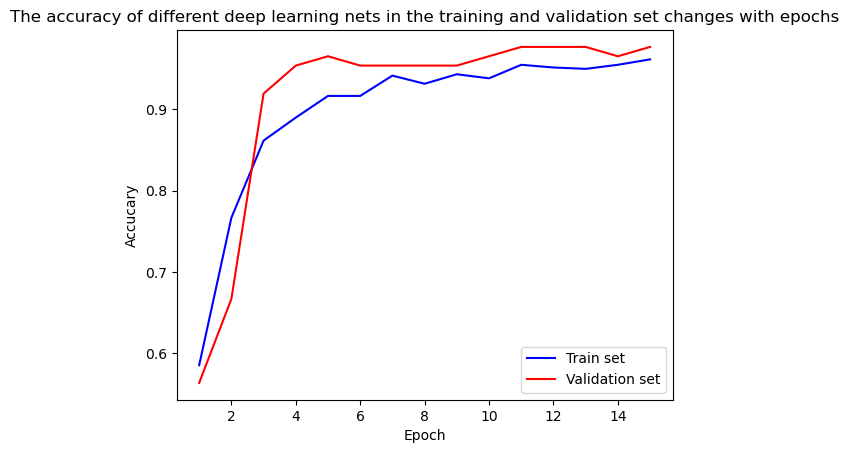

In [35]:
##准确性
plt.plot(range(1, epochs+1), train_acc, label='Train set', color='#0000FF')
plt.plot(range(1, epochs+1), verif_acc, label='Validation set', color='#FF0000')
plt.title('The accuracy of different deep learning nets in the training and validation set changes with epochs')
plt.xlabel('Epoch')
plt.ylabel('Accucary')
plt.legend()
Fig2 = plt.gcf() 
Fig2.savefig(r'D:\CNNswe\resmnet_acc.svg')

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dl_train:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # 前向传播
        outputs = model(inputs)
        
        # 获取预测结果
        _, preds = torch.max(outputs, 1)
        
        # 收集预测值和真实标签
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print(cm) 

# 计算准确率
accuracy = accuracy_score(all_labels, all_preds)
print("准确率:", accuracy)

# 计算精准度
precision = precision_score(all_labels, all_preds, average='binary')  # 'weighted'用于多类别情况
print("精准度:", precision)

# 计算召回率
recall = recall_score(all_labels, all_preds, average='binary')
print("召回率:", recall)

# 计算F1分数
f1 = f1_score(all_labels, all_preds, average='binary')
print("F1分数:", f1)

[[277   5]
 [  8 310]]
准确率: 0.9783333333333334
精准度: 0.9841269841269841
召回率: 0.9748427672955975
F1分数: 0.9794628751974723


In [37]:
model.eval()
all_preds1 = []
all_labels1 = []
all_pred_probs1 = []

with torch.no_grad():
    for inputs, labels in dl_test:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # 前向传播
        outputs = model(inputs)
        
        # 获取预测结果
        _, preds = torch.max(outputs, 1)

        # 计算分类概率
        probs = F.softmax(outputs, dim=1)
        
        # 收集预测值和真实标签
        all_preds1.extend(preds.cpu().numpy())
        all_labels1.extend(labels.cpu().numpy())
        all_pred_probs1.extend(probs.cpu().numpy())

# 计算混淆矩阵
cm1 = confusion_matrix(all_labels1, all_preds1)
print(cm1) 

# 计算准确率
accuracy1 = accuracy_score(all_labels1, all_preds1)
print("准确率:", accuracy1)

# 计算精准度
precision1 = precision_score(all_labels1, all_preds1, average='binary')  # 'weighted'用于多类别情况
print("精准度:", precision1)

# 计算召回率
recall1 = recall_score(all_labels1, all_preds1, average='binary')
print("召回率:", recall1)

# 计算F1分数
f11 = f1_score(all_labels1, all_preds1, average='binary')
print("F1分数:", f11)

import pandas as pd
# 将测试集的预测标签和真实标签保存为 Excel 文件
data = {
    '真实标签': all_labels1,
    '预测标签': [prob[1] for prob in all_pred_probs1]
}
df = pd.DataFrame(data)
df.to_excel('res_test_labels.xlsx', index=False)

[[76  5]
 [ 9 81]]
准确率: 0.9181286549707602
精准度: 0.9418604651162791
召回率: 0.9
F1分数: 0.9204545454545454


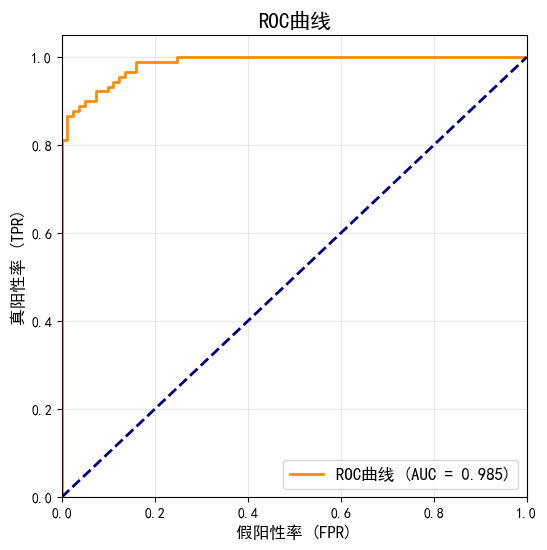

In [38]:
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制ROC曲线
plt.figure(figsize=(6, 6))


# 提取正类概率
y_score = np.array([prob[1] for prob in all_pred_probs1])
    
# 计算ROC曲线点
fpr, tpr, _ = roc_curve(all_labels1, y_score)
roc_auc = auc(fpr, tpr)
    
# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC曲线 (AUC = {roc_auc:.3f})')

# 绘制随机猜测线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 添加标签和标题
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (FPR)', fontsize=12)
plt.ylabel('真阳性率 (TPR)', fontsize=12)
plt.title('ROC曲线', fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
# 保存图像
plt.show()

In [39]:
model.eval()
all_preds2 = []
all_labels2 = []
all_pred_probs2 = []

with torch.no_grad():
    for inputs, labels in dl_verif:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        # 前向传播
        outputs = model(inputs) 
        
        # 获取预测结果
        _, preds = torch.max(outputs, 1)
        
        # 计算分类概率
        probs = F.softmax(outputs, dim=1)
        
        # 收集预测值和真实标签
        all_preds2.extend(preds.cpu().numpy())
        all_labels2.extend(labels.cpu().numpy())
        all_pred_probs2.extend(probs.cpu().numpy())

# 计算混淆矩阵
cm2 = confusion_matrix(all_labels2, all_preds2)
print(cm2) 

# 计算准确率
accuracy2 = accuracy_score(all_labels2, all_preds2)
print("准确率:", accuracy2)

# 计算精准度
precision2 = precision_score(all_labels2, all_preds2, average='binary')  # 'weighted'用于多类别情况
print("精准度:", precision2)

# 计算召回率
recall2 = recall_score(all_labels2, all_preds2, average='binary')
print("召回率:", recall2)

# 计算F1分数
f12 = f1_score(all_labels2, all_preds2, average='binary')
print("F1分数:", f12)

import pandas as pd
# 将测试集的预测标签和真实标签保存为 Excel 文件
data2 = {
    '真实标签': all_labels2,
    '预测标签': [prob[1] for prob in all_pred_probs2]
}
df = pd.DataFrame(data2)
df.to_excel('res_verif_labels.xlsx', index=False)

[[41  1]
 [ 1 44]]
准确率: 0.9770114942528736
精准度: 0.9777777777777777
召回率: 0.9777777777777777
F1分数: 0.9777777777777777


In [40]:
torch.save(model,'sweresnet.pkl')

In [ ]:
model=torch.load('sweresnet.pkl')
model